In [1]:

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
import cv2
import os
import random
import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt



In [2]:
def lower_face_mask(h, w):

    mask = np.ones((h, w), np.float32)

    top = int(0.50 * h)
    bottom = int(0.92 * h)
    left = int(0.20 * w)
    right = int(0.80 * w)

    mask[top:bottom, left:right] = 0

    kernel = np.zeros((h, w), np.uint8)
    cv2.ellipse(
        kernel,
        ((left + right)//2, (top + bottom)//2),
        ((right-left)//2, (bottom-top)//2),
        0, 0, 360, 1, -1
    )

    mask = mask * kernel + (1 - kernel)

    mask = cv2.GaussianBlur(mask, (31, 31), 0)
    mask = (mask > 0.5).astype(np.float32)

    return torch.from_numpy(mask).unsqueeze(0)


In [3]:
def generate_mask(h, w):
    mask = np.ones((h, w), np.float32)

    y_jitter = random.randint(-6, 6)
    x_jitter = random.randint(-8, 8)

    top = int(0.60 * h) + y_jitter
    bottom = int(0.95 * h)
    left = int(0.22 * w) + x_jitter
    right = int(0.78 * w) + x_jitter

    top = max(top, 0)
    left = max(left, 0)
    bottom = min(bottom, h)
    right = min(right, w)

    mask[top:bottom, left:right] = 0
    face_shape = np.ones((h, w), np.uint8)
    cv2.ellipse(
        face_shape,
        ((left + right)//2, (top + bottom)//2),
        (int((right-left)*0.45), int((bottom-top)*0.55)),
        0, 0, 360, 0, -1
    )

    mask = np.minimum(mask, face_shape)

    mask = cv2.GaussianBlur(mask, (31, 31), 0)
    mask = np.clip(mask, 0, 1)

    return torch.from_numpy(mask).unsqueeze(0)


In [4]:
class FaceDataset(Dataset):
    def __init__(self, img_dir, size=256):
        self.imgs = [
            os.path.join(img_dir, f)
            for f in os.listdir(img_dir)
            if f.lower().endswith(('.jpg', '.png'))
        ]

        self.transform = transforms.Compose([
            transforms.Resize((size, size)),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img = Image.open(self.imgs[idx]).convert("RGB")
        img = self.transform(img)

        mask = generate_mask(img.shape[1], img.shape[2])
        mask = mask.float()
        masked_img = img * mask

        return masked_img, mask, img


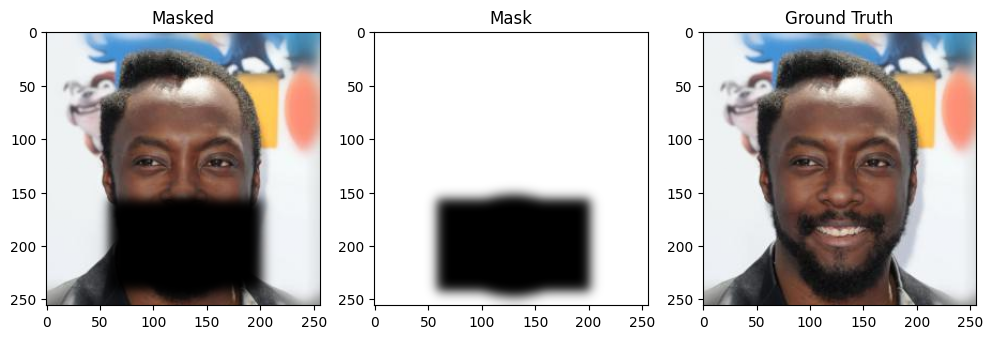

In [5]:
dataset = FaceDataset("/kaggle/input/celebahq-f/celeba_hq_256")
masked, mask, real = dataset[0]

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(masked.permute(1,2,0)); plt.title("Masked")
plt.subplot(1,3,2); plt.imshow(mask[0], cmap="gray"); plt.title("Mask")
plt.subplot(1,3,3); plt.imshow(real.permute(1,2,0)); plt.title("Ground Truth")
plt.show()


In [6]:
class PartialConv2d(nn.Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        kernel_size=3,
        stride=1,
        padding=1,
        bias=True
    ):
        super().__init__()

        self.input_conv = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            bias=bias
        )

        self.mask_conv = nn.Conv2d(
            1,
            out_channels,
            kernel_size,
            stride,
            padding,
            bias=False
        )

        torch.nn.init.constant_(self.mask_conv.weight, 1.0)
        for p in self.mask_conv.parameters():
            p.requires_grad = False

    def forward(self, x, mask):
        """
        x    : (B, C, H, W)
        mask : (B, 1, H, W)
        """

        with torch.no_grad():
            mask_out = self.mask_conv(mask)

        out = self.input_conv(x * mask)

        eps = 1e-8
        out = out * (mask_out > 0).float() / (mask_out + eps)

        new_mask = (mask_out > 0).float()
        new_mask = torch.max(new_mask, dim=1, keepdim=True)[0]

        return out, new_mask


In [7]:
class PConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, downsample=True):
        super().__init__()
        self.downsample = downsample

        self.pconv = PartialConv2d(in_ch, out_ch)
        self.bn = nn.BatchNorm2d(out_ch)
        self.relu = nn.ReLU(inplace=True)

        if downsample:
            self.pool = nn.MaxPool2d(2)

    def forward(self, x, mask):

        x, mask = self.pconv(x, mask)
        x = self.bn(x)
        x = self.relu(x)

        if self.downsample:
            x = self.pool(x)
            mask = self.pool(mask)

        return x, mask


In [8]:
class PConvUpBlock(nn.Module):
    def __init__(self, in_ch_from_decoder, in_ch_from_encoder_skip, out_ch):
        super().__init__()

        self.up = nn.Upsample(scale_factor=2, mode="nearest")

        self.pconv = PartialConv2d(
            in_ch_from_decoder + in_ch_from_encoder_skip,
            out_ch,
            kernel_size=3,
            stride=1,
            padding=1
        )

        self.bn = nn.BatchNorm2d(out_ch)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x, mask, skip_x, skip_mask):
        x = self.up(x)
        mask = self.up(mask)

        if skip_x is not None:
            x = torch.cat([x, skip_x], dim=1)
            mask = torch.max(mask, skip_mask)

        x, mask = self.pconv(x, mask)
        x = self.bn(x)
        x = self.relu(x)

        return x, mask


In [10]:
class PConvUNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.e1 = PConvBlock(3, 64)      # 256 → 128
        self.e2 = PConvBlock(64, 128)    # 128 → 64
        self.e3 = PConvBlock(128, 256)   # 64 → 32
        self.e4 = PConvBlock(256, 512)   # 32 → 16

        self.mid = PConvBlock(512, 512, downsample=False)

        self.d4 = PConvUpBlock(512, 256, 256)  # 16 → 32
        self.d3 = PConvUpBlock(256, 128, 128)  # 32 → 64
        self.d2 = PConvUpBlock(128, 64, 64)    # 64 → 128

        self.d1 = PConvUpBlock(64, 0, 64)      # 128 → 256

        self.final = PartialConv2d(
            64,
            3,
            kernel_size=3,
            stride=1,
            padding=1
        )

    def forward(self, x, mask):

        e1, m1 = self.e1(x, mask)
        e2, m2 = self.e2(e1, m1)
        e3, m3 = self.e3(e2, m2)
        e4, m4 = self.e4(e3, m3)

        mid, mm = self.mid(e4, m4)

        d4, md4 = self.d4(mid, mm, e3, m3)
        d3, md3 = self.d3(d4, md4, e2, m2)
        d2, md2 = self.d2(d3, md3, e1, m1)

        d1, md1 = self.d1(d2, md2, None, None)

        out, _ = self.final(d1, md1)
        return torch.tanh(out)


In [11]:
def snconv(in_c, out_c, k, s, p):
    return nn.utils.spectral_norm(
        nn.Conv2d(in_c, out_c, k, s, p)
    )

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            snconv(3, 64, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),

            snconv(64, 128, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),

            snconv(128, 256, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),

            snconv(256, 512, 4, 1, 1),
            nn.LeakyReLU(0.2, inplace=True),

            snconv(512, 1, 4, 1, 1)
        )

    def forward(self, x):
        return self.net(x)


In [13]:
def feature_matching_loss(D, real, fake):
    loss = 0
    x_real, x_fake = real, fake

    for layer in D.net[:-1]:
        x_real = layer(x_real)
        x_fake = layer(x_fake)
        loss += torch.mean(torch.abs(x_real - x_fake))

    return loss


In [12]:
class PerceptualLoss(nn.Module):
    def __init__(self):
        super().__init__()

        vgg = models.vgg19(pretrained=True).features
        self.layers = nn.ModuleList([
            vgg[:4],
            vgg[:9],
            vgg[:16]
        ])

        for p in self.parameters():
            p.requires_grad = False

        self.register_buffer(
            "mean", torch.tensor([0.485, 0.456, 0.406]).view(1,3,1,1)
        )
        self.register_buffer(
            "std", torch.tensor([0.229, 0.224, 0.225]).view(1,3,1,1)
        )

    def forward(self, fake, real, mask):

        fake = (fake + 1) / 2
        real = (real + 1) / 2

        fake = (fake - self.mean) / self.std
        real = (real - self.mean) / self.std

        loss = 0
        for layer in self.layers:
            f_fake = layer(fake)
            f_real = layer(real)
            loss += torch.mean(torch.abs(f_fake - f_real))

        return loss


In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"

G = PConvUNet().to(device)
D = Discriminator().to(device)
perc = PerceptualLoss().to(device)

optG = optim.Adam(
    G.parameters(),
    lr=2e-4,
    betas=(0.5, 0.999)
)

optD = optim.Adam(
    D.parameters(),
    lr=1e-4,
    betas=(0.5, 0.999)
)

l1_loss = nn.SmoothL1Loss(beta=1.0)
bce_loss = nn.BCEWithLogitsLoss()


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


100%|██████████| 548M/548M [00:02<00:00, 211MB/s] 


In [14]:
def train(loader, epochs=10, lambda_gan=0.1):

    G.train()
    D.train()

    total_steps = epochs * len(loader)
    warmup_steps = int(0.3 * total_steps)
    global_step = 0

    for epoch in range(epochs):
        pbar = tqdm(loader)

        for step, (masked, mask, real) in enumerate(pbar):
            masked = masked.to(device)
            mask = mask.to(device)
            real = real.to(device)

            fake = G(masked, mask)

            L_rec = l1_loss(fake * (1 - mask), real * (1 - mask))
            L_perc = perc(fake, real, mask)

            if global_step < warmup_steps:
                L_adv = torch.tensor(0.0, device=device)
            else:
                blended = fake * (1 - mask) + real * mask
                pred_fake = D(blended)
                L_adv = bce_loss(pred_fake, torch.ones_like(pred_fake))

            lossG = (
                1.0 * L_rec +
                0.1 * L_perc +
                lambda_gan * L_adv
            )

            optG.zero_grad()
            lossG.backward()
            optG.step()

            if global_step >= warmup_steps:
                pred_real = D(real * (1 - mask))
                pred_fake = D(fake.detach() * (1 - mask))

                lossD_real = bce_loss(pred_real, torch.ones_like(pred_real))
                lossD_fake = bce_loss(pred_fake, torch.zeros_like(pred_fake))

                lossD = 0.5 * (lossD_real + lossD_fake)

                optD.zero_grad()
                lossD.backward()
                optD.step()
            else:
                lossD = torch.tensor(0.0)


            pbar.set_description(
                f"E{epoch+1} | step {global_step}/{total_steps} | "
                f"G:{lossG.item():.3f} "
                f"(L1:{L_rec.item():.3f} P:{L_perc.item():.3f} GAN:{L_adv.item():.3f}) "
                f"| D:{lossD.item():.3f}"
            )

            global_step += 1

        print(f"Epoch {epoch+1} DONE | G={lossG.item():.4f} D={lossD.item():.4f}")


In [ ]:
loader = DataLoader(dataset, batch_size=16, shuffle=True)
train(loader, epochs=10)


In [ ]:
with torch.no_grad():
    masked, mask, real = dataset[1]
    fake = G(masked.unsqueeze(0).to(device), mask.unsqueeze(0).to(device))

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(masked.permute(1,2,0)); plt.title("Masked")
plt.subplot(1,3,2); plt.imshow(fake[0].cpu().permute(1,2,0)); plt.title("Reconstructed")
plt.subplot(1,3,3); plt.imshow(real.permute(1,2,0)); plt.title("GT")
plt.show()

In [ ]:
os.makedirs("checkpoints", exist_ok=True)

torch.save({
    "G": G.state_dict(),
    "D": D.state_dict(),
    "optG": optG.state_dict(),
    "optD": optD.state_dict()
}, "checkpoints/inpainting_gan.pth")


In [ ]:
torch.save(G.state_dict(), "checkpoints/G_only.pth")


In [ ]:
!zip -r model_export.zip checkpoints/


In [ ]:
from google.colab import files
files.download("model_export.zip")
